In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models import individual, parallel, task_switching
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm, calculate_rsa, calculate_rsa_diagonal
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_rdm_sequential = os.path.join('svg', 'figure03bc_rdm_sequential.svg')
path_figure_rdm_parallel = os.path.join('svg', 'figure03bc_rdm_parallel.svg')
path_figure_rdm_first = os.path.join('svg', 'figure03bc_rdm_first.svg')
path_figure_rdm_last = os.path.join('svg', 'figure03bc_rdm_last.svg')
path_figure_rsa_b = os.path.join('svg', 'figure03b_rsa_contexts.svg')
path_figure_rsa_c = os.path.join('svg', 'figure03c_rsa_contexts.svg')
path_model_sequential = os.path.join('..', '..', 'results', 'individual')
path_model_parallel = os.path.join('..', '..', 'results', 'parallel')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

## Sequential

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = None

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_sequential, parameters)

Found simulation in ../../results/individual with the same parameters (2022-09-28_01_16_35)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [7]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

list_sm_sequential = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_numbers = []
    indices = results_individual[seed]['indices']

    for i_task, task_name in enumerate(tasks_names):
        state_dict = results_individual[seed][task_name]['model']

        model = individual.get_individual_model(num_hidden, device)
        model.load_state_dict(state_dict)
        model.to(device)

        task_dataset = tasks_datasets[task_name]
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=batch_size)

        numbers = testloader.dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        _, activations = individual.hooks.get_layer_activations(model,
                                                                testloader,
                                                                criterion,
                                                                device=device,
                                                                disable=True)
        
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                            tasks_names=tasks_names)

    list_sm_sequential.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

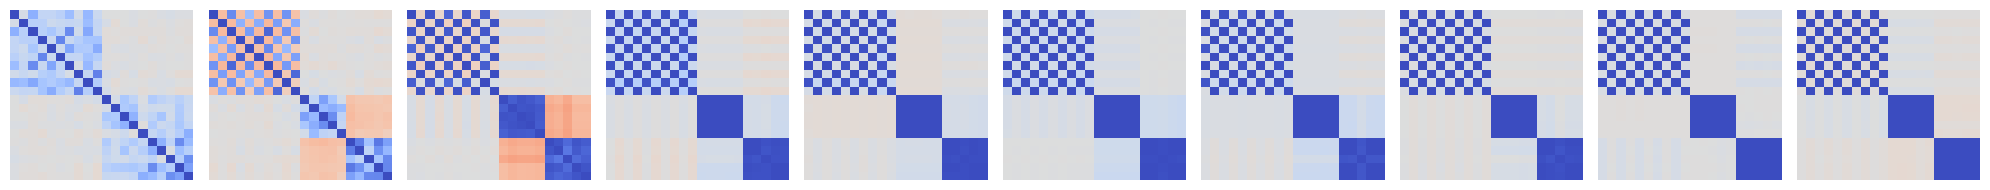

In [10]:
mean_rdm_sequential = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_sequential[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_sm_sequential:
        mean_rdm_sequential[layer+1] += rdm[layer+1]
    mean_rdm_sequential[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_sequential, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()
# fig.savefig(path_figure_rdm_sequential)
plt.show()

## Parallel

In [11]:
data_folder = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/parallel with the same parameters (2022-09-28_01_56_10)


In [12]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_parallel = pickle.load(handle)

In [13]:
seeds = sorted(list(results_parallel.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [14]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [15]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

In [16]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
num_tasks = len(tasks_names)
list_rdm_parallel = []


for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = parallel.get_parallel_model(num_tasks,
                                        num_hidden,
                                        device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
    numbers = numbers[indices['test']]
    
    _, activations = parallel.hooks.get_layer_activations(model,
                                                          parallel_testloader,
                                                          criterion=criterion,
                                                          device=device,
                                                          disable=True)
    
    task_activations = []
    task_numbers = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)


    list_rdm_parallel.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

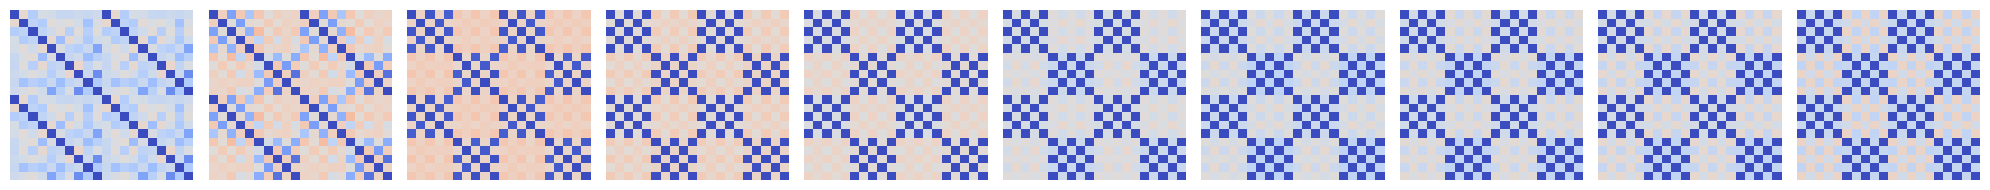

In [17]:
mean_rdm_parallel = {}

for layer in range(num_layers):
    mean_rdm_parallel[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_parallel:
        mean_rdm_parallel[layer+1] += rdm[layer+1]
    mean_rdm_parallel[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_parallel, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()
# fig.savefig(path_figure)
plt.show()

## Contexts First

In [18]:
idxs_contexts = [0]
parameters['idxs_contexts'] = idxs_contexts

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_11)


In [19]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [20]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [21]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [22]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))
list_rdm_task_switching_first = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = task_switching.get_task_model(task_switching_tasks,
                                          num_hidden,
                                          idxs_contexts,
                                          device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = \
        task_switching.hooks.get_layer_activations(model,
                                                   tasks_testloader,
                                                   criterion,
                                                   device=device,
                                                   disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    
    list_rdm_task_switching_first.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

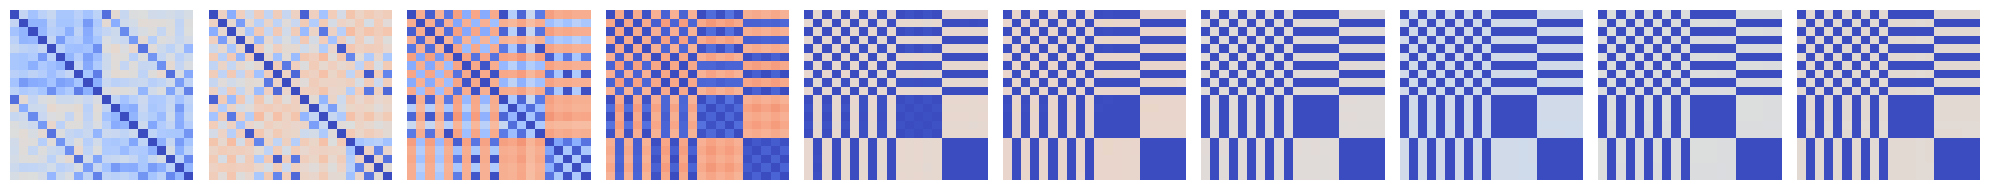

In [23]:
mean_rdm_first = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_first[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_task_switching_first:
        mean_rdm_first[layer+1] += rdm[layer+1]
    mean_rdm_first[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_first, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()

# fig.savefig(path_figure_rdm_first)

plt.show()

## Context Last

In [24]:
idxs_contexts = [9]
parameters['idxs_contexts'] = idxs_contexts

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_20)


In [25]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [26]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))
list_rdm_task_switching_last = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = task_switching.get_task_model(task_switching_tasks,
                                          num_hidden,
                                          idxs_contexts,
                                          device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = \
        task_switching.hooks.get_layer_activations(model,
                                                   tasks_testloader,
                                                   criterion,
                                                   device=device,
                                                   disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    
    list_rdm_task_switching_last.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

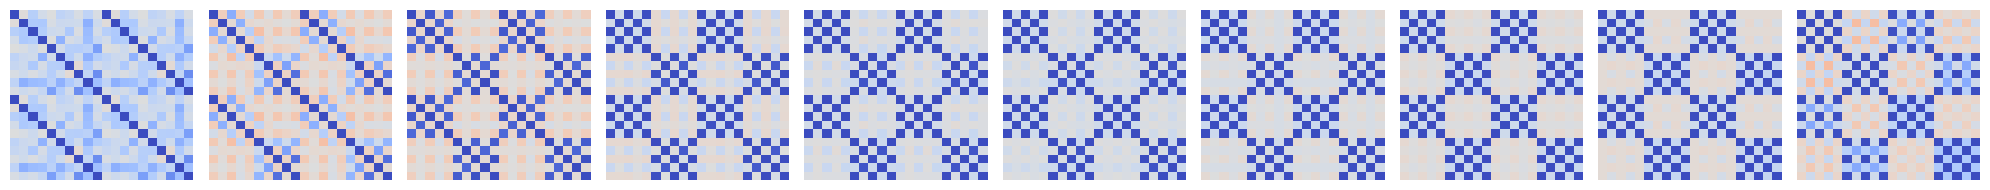

In [27]:
mean_rdm_last = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_last[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_task_switching_last:
        mean_rdm_last[layer+1] += rdm[layer+1]
    mean_rdm_last[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_last, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()

# fig.savefig(path_figure_rdm_last)

plt.show()

## RSA

In [31]:
rsa_sequential_first = \
    calculate_rsa_diagonal(list_sm_sequential,
                           list_rdm_task_switching_first,
                           num_inputs=10)

mean_sequential_first = rsa_sequential_first.mean(axis=0)
std_sequential_first = rsa_sequential_first.std(axis=0)

rsa_parallel_last = \
    calculate_rsa_diagonal(list_rdm_parallel,
                           list_rdm_task_switching_last,
                           num_inputs=10)

mean_parallel_last = rsa_parallel_last.mean(axis=0)
std_parallel_last = rsa_parallel_last.std(axis=0)

In [35]:
median_sequential_first = np.median(rsa_sequential_first, axis=0)
percentile_25_sequential_first = np.percentile(rsa_sequential_first, 25, axis=0)
percentile_75_sequential_first = np.percentile(rsa_sequential_first, 75, axis=0)

median_parallel_last = np.median(rsa_parallel_last, axis=0)
percentile_25_parallel_last = np.percentile(rsa_parallel_last, 25, axis=0)
percentile_75_parallel_last = np.percentile(rsa_parallel_last, 75, axis=0)

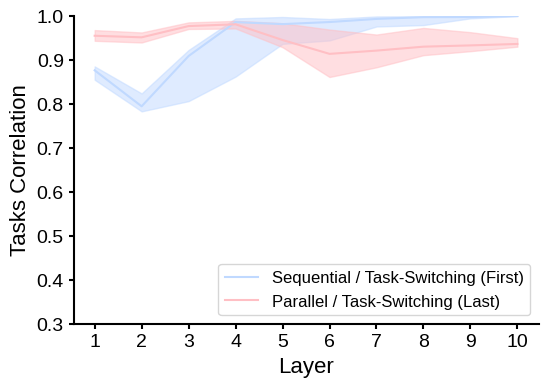

In [39]:
layers = range(1, num_layers + 1)
fig = plt.figure(figsize=(6, 4))

plt.plot(layers, median_sequential_first, color=palette[0])
plt.plot(layers, mean_parallel_last, color=palette[-1])

plt.fill_between(layers,
                 percentile_25_sequential_first,
                 percentile_75_sequential_first,
                 alpha=0.5,
                 color=palette[0])

plt.fill_between(layers,
                 percentile_25_parallel_last,
                 percentile_75_parallel_last,
                 alpha=0.5,
                 color=palette[-1])

plt.xlabel('Layer')
plt.xticks(range(1, num_layers+1))
plt.legend(['Sequential / Task-Switching (First)', 'Parallel / Task-Switching (Last)'], loc='lower right', prop={'size':12})
plt.ylabel('Tasks Correlation')
plt.ylim(0.3, 1)
fig.savefig(path_figure_rsa_b)

plt.show()

In [41]:
rsa_sequential_last = \
    calculate_rsa_diagonal(list_sm_sequential,
                           list_rdm_task_switching_last,
                           num_inputs=10)

mean_sequential_last = rsa_sequential_last.mean(axis=0)
std_sequential_last = rsa_sequential_last.std(axis=0)

rsa_parallel_first = \
    calculate_rsa_diagonal(list_rdm_parallel,
                           list_rdm_task_switching_first,
                           num_inputs=10)

mean_parallel_first = rsa_parallel_first.mean(axis=0)
std_parallel_first = rsa_parallel_first.std(axis=0)

In [46]:
median_sequential_last = np.median(rsa_sequential_last, axis=0)
percentile_25_sequential_last = np.percentile(rsa_sequential_last, 25, axis=0)
percentile_75_sequential_last = np.percentile(rsa_sequential_last, 75, axis=0)

median_parallel_first = np.median(rsa_parallel_first, axis=0)
percentile_25_parallel_first = np.percentile(rsa_parallel_first, 25, axis=0)
percentile_75_parallel_first = np.percentile(rsa_parallel_first, 75, axis=0)

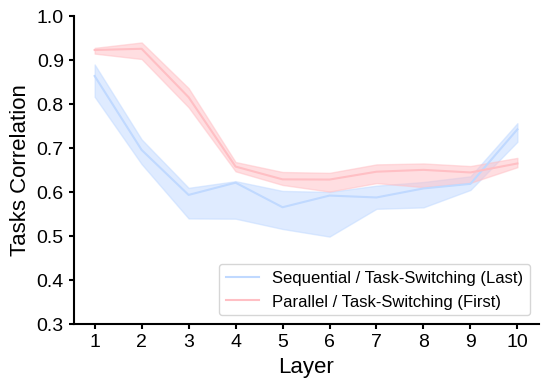

In [47]:
layers = range(1, num_layers + 1)
fig = plt.figure(figsize=(6, 4))

plt.plot(layers, median_sequential_last, color=palette[0])
plt.plot(layers, median_parallel_first, color=palette[-1])

plt.fill_between(layers,
                 percentile_25_sequential_last,
                 percentile_75_sequential_last,
                 alpha=0.5,
                 color=palette[0])

plt.fill_between(layers,
                 percentile_25_parallel_first,
                 percentile_75_parallel_first,
                 alpha=0.5,
                 color=palette[-1])

plt.xlabel('Layer')
plt.xticks(range(1, num_layers+1))
plt.ylabel('Pearson Correlation')
plt.legend(['Sequential / Task-Switching (Last)', 'Parallel / Task-Switching (First)'], loc='lower right', prop={'size':12})
plt.ylabel('Tasks Correlation')
plt.ylim(0.3, 1)
fig.savefig(path_figure_rsa_c)

plt.show()